# Домашнее задание к Уроку 7

- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

#### Загрузим необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import shap
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, train, DMatrix
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 

#### Описание датасета

Данные связаны с кампаниями прямого маркетинга португальского банковского учреждения.

Маркетинговые кампании были основаны на телефонных звонках. Часто требовалось более одного контакта с одним и тем же клиентом,
чтобы обкеспечить согласие на доступ к подписке на продукт (срочный банковский депозит).

**Датасет содержит следующтие признаки:**
    
   1 - age (numeric) - возраст
   
   2 - job : тип работы (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")
                                       
   3 - marital : семейное положение (categorical: "married","divorced","single";)
   
   
   4 - education (categorical: "unknown","secondary","primary","tertiary") - образование
   
   5 - default: (binary: "yes","no") - наличие кредита
   
   6 - balance: среднегодовой баланс в евро (numeric) 
   
   7 - housing: наличие ипотеки? (binary: "yes","no") 
   
   8 - loan: наличие потребительского кредита? (binary: "yes","no") 
   
   **Признаки связанные с последней маркетиновой компанией:**
   
   9 - contact: канал взаимодействия (categorical: "unknown","telephone","cellular") 
   
  10 - day: день месяца последнего контакта (numeric) 
  
  11 - month: месяц последнего контакта (categorical: "jan", "feb", "mar", ..., "nov", "dec") -  
  
  12 - duration: продолжительность последнего контакта, в секундах (numeric)
  
  **прочие признаки:**
  
  13 - campaign: Общее количество контактов в рамках компании для клиента
  
  14 - pdays: количество дней, прошедших с момента последнего контакта с клиентом из предыдущей кампании (numeric, -1 значит что с клиентом не контактировали в предыдущих компаниях)
  
  15 - previous: количество контактов с клиентом, до этой кампании (numeric)
  
  16 - poutcome: результат предыдущей маркетинговой кампании (categorical: "unknown","other","failure","success")

  **Целевой признак**:
  
  17 - y - подписал ли клиент срочный депозит? (binary: "yes","no")

#### Загрузим датасеты

In [4]:
df = pd.read_csv('bank-full.csv', sep=';')

In [5]:
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [6]:
df.shape

(45211, 17)

Посмотрим на cоотношение классов целевого признака:

In [7]:
df['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

Очевиден дисбаланс классов

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Пропуски отсутствуют

In [9]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Сразу выполним преобразование целевого признака:

In [10]:
# Произведем мапинг на 0 и 1 для признака y
binary_dict = {'no': 0, 'yes': 1}
df['y'] = df['y'].map(binary_dict).astype(int)

Разабьем датасет на тренировочный и тестовый:

In [11]:
target = df['y']
X = df.iloc[:, :-1]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=7)

In [13]:
X_train.shape

(31647, 16)

In [14]:
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
ohe_columns = ['job', 'marital', 'education', 'contact']
numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

#### Обработка признаков

Сначала обработаем бинарные признаки:

In [15]:
# Произведем мапинг на 0 и 1 для признака default
X_train['default'] = X_train['default'].map(binary_dict).astype(int)
X_test['default'] = X_test['default'].map(binary_dict).astype(int)

# Произведем мапинг на 0 и 1 для признака housing
X_train['housing'] = X_train['housing'].map(binary_dict).astype(int)
X_test['housing'] = X_test['housing'].map(binary_dict).astype(int)

# Произведем мапинг на 0 и 1 для признака loan
X_train['loan'] = X_train['loan'].map(binary_dict).astype(int)
X_test['loan'] = X_test['loan'].map(binary_dict).astype(int)

# Для признака poutcome будем считать 1 только для success все остальное пометим как 0
poutcome_dict = {'unknown': 0, 'failure': 0, 'other': 0, 'success': 1}
X_train['poutcome'] = X_train['poutcome'].map(poutcome_dict).astype(int)
X_test['poutcome'] = X_test['poutcome'].map(poutcome_dict).astype(int)

Обработаем оставшиеся категориальные признаки:

In [16]:
# Для признака month наименование месяцев переведем в их цифровое обозначение
month_dict = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
              'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
X_train['month'] = X_train['month'].map(month_dict).astype(int)
X_test['month'] = X_test['month'].map(month_dict).astype(int)

In [17]:
# Остальные категориальные признаси обработаем через OHE
X_train = pd.get_dummies(X_train, columns=ohe_columns)
X_test = pd.get_dummies(X_test, columns=ohe_columns)

#### Модель XGBoost

Обучим модель

In [18]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [19]:
continuous_columns = X_train.columns.to_list()

In [20]:
final_transformers = list()
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))
    
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [21]:
regressor = Pipeline([
    ('features',feats),
    ('classifier', XGBClassifier()),
])

#обучим наш пайплайн
regressor.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='age'))])),
                                                ('default',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='default'))])),
                                                ('balance',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='balance'))])),
                                                ('housing',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='housing'))])),
                       

In [22]:
predictions =  regressor.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(0.09149218519610734, 0.08784514160058376)

In [23]:
xgb_features = pd.DataFrame(regressor[1].feature_importances_, 
                        continuous_columns, 
                        columns=['coefficient'])
xgb_features.head()

,coefficient
age,0.015047
default,0.006724
balance,0.013150
housing,0.059054
loan,0.034839


### SHAP

In [24]:
# load JS visualization code to notebook
shap.initjs()

In [25]:
model = train({"learning_rate": 0.01}, 
               DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

#### Построим важность признаков для всего тестового набора данных

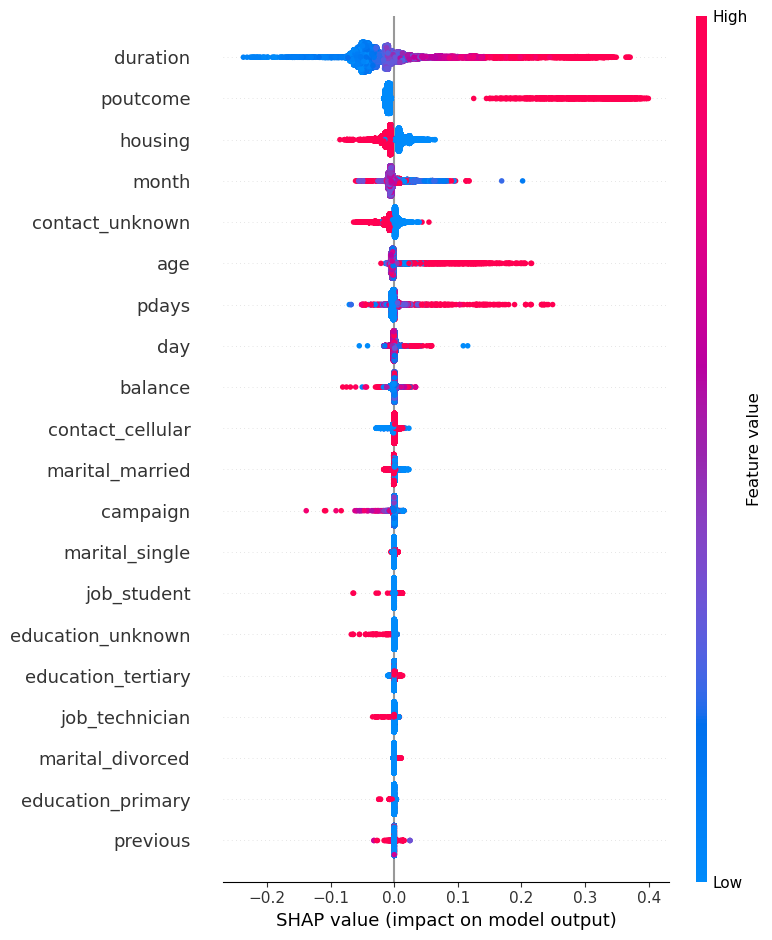

In [26]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Из данного графика можно сделать вывод что наиболее значимыми признаками являються:

    1. duration - время в секундах потраченное на беседу с клиентом в последнюю компанию
    2. poutcome - успешность результата предыдущей маркетинговой компании
    3. age - возраст клиета
    4. pdays -количество дней с момента контакта с клиентом в предыдущей компании

#### Построим важность признаков для всего топ 10 набора данных

In [27]:
top_10 = int(X_train.shape[0] * 0.1)

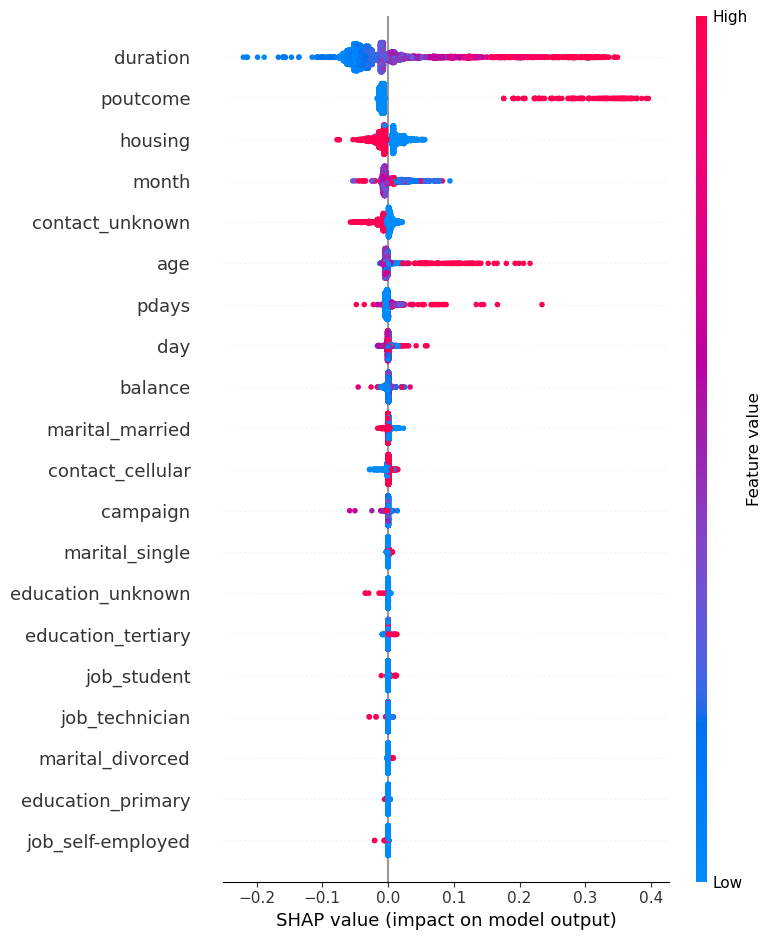

In [28]:
# summarize the effects of all the features
shap.summary_plot(shap_values[:top_10], X_train[:top_10])

В целом картина не поменялась

#### Построим важность признаков для отдельных наблюдений

In [41]:
shap.force_plot(explainer.expected_value, shap_values[:1], X_train.iloc[:1])

In [42]:
shap.force_plot(explainer.expected_value, shap_values[99:100], X_train.iloc[99:100])

In [43]:
shap.force_plot(explainer.expected_value, shap_values[999:1000], X_train.iloc[999:1000])

In [44]:
shap.force_plot(explainer.expected_value, shap_values[9999:10000], X_train.iloc[9999:10000])

In [45]:
shap.force_plot(explainer.expected_value, shap_values[19999:20000], X_train.iloc[19999:20000])

Из графиков выше можно сделать следующий вывод:
    
    1. Парадоксально но отсутствие у клиента ипотеки отрицательно влияет на подписание срочного депозита
    2. Положительно на подписание срочного депозита влияет количество времени общения с клиентом в рамках компании, чем дольше тем лучше